In [1]:
import pandas as pd
import numpy as np
import geojson

import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from ast import literal_eval
import collections

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings('ignore')

In [2]:
city = 'barcelona'

### raw, original files with all datapoints
listings_link = 'data/' + city + '/listings.csv.gz'
#reviews_link = 'data/' + city + '/reviews.csv.gz'
calendar_link = 'data/' + city + '/calendar.csv.gz'

### shortened summary of listings: just a few main features from the original file
listings_sum_link = 'data/' + city + '/listings.csv'

### neighborhood information
neighborhoods_link = 'data/' + city + '/neighbourhoods.csv'
neighborhoods_gjson_link = 'data/' + city + '/neighbourhoods.geojson'

In [42]:
### read 'big' gzipped files
listings = pd.read_csv(listings_link, compression = 'gzip', error_bad_lines = False)
#reviews = pd.read_csv(reviews_link, compression = 'gzip', error_bad_lines = False)
calendar = pd.read_csv(calendar_link, compression = 'gzip', error_bad_lines = False)

### read neighborhhood info
neighborhoods = pd.read_csv(neighborhoods_link)

### read summarized data of listings
listings_summarized = pd.read_csv(listings_sum_link)

### read geojson with neighborhood geo data
with open(neighborhoods_gjson_link) as f:
    neighborhoods_gjson = geojson.load(f)

### Check files

Listings summarized is just a few of the original features, plus the grouped neighborhood. I'll go over all features and select the necessary ones and do feature engineering manually

In [43]:
listings.head(2)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,18674,https://www.airbnb.com/rooms/18674,20210707180233,2021-07-07,Huge flat for 8 people close to Sagrada Familia,110m2 apartment to rent in Barcelona. Located ...,Apartment in Barcelona located in the heart of...,https://a0.muscache.com/pictures/13031453/413c...,71615,https://www.airbnb.com/users/show/71615,...,4.90,4.75,4.30,HUTB-002062,t,18,18,0,0,0.23
1,23197,https://www.airbnb.com/rooms/23197,20210707180233,2021-07-08,Forum CCIB DeLuxe★Spacious &Elegant★Large Balcony,"Beautiful spacious apartment, large terrace, 5...",Strategically located in the Parc del Fòrum ar...,https://a0.muscache.com/pictures/738532/806da1...,90417,https://www.airbnb.com/users/show/90417,...,4.98,4.67,4.69,HUTB-005057,f,2,2,0,0,0.78


In [44]:
listings_summarized.head(2)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,18674,Huge flat for 8 people close to Sagrada Familia,71615,Mireia And Maria,Eixample,la Sagrada Família,41.40556,2.17262,Entire home/apt,169,1,21,2019-10-11,0.23,18,60
1,23197,Forum CCIB DeLuxe★Spacious &Elegant★Large Balcony,90417,Etain (Marnie),Sant Martí,el Besòs i el Maresme,41.41291,2.22063,Entire home/apt,240,3,52,2019-12-15,0.78,2,169


In [45]:
# reviews.head(2)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,18674,4808211,2013-05-27,4841196,Caron,"Great location. Clean, spacious flat. Would re..."
1,18674,10660311,2014-03-02,11600277,Juan Carlos,Mi mejor recomendación para este departamento....


Calendar includes daily prices for up to a year. Monthly aggregation, or just simple overall median can be taken..

In [46]:
calendar.head(2)

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,275889,2021-07-07,f,$287.00,$287.00,32.0,365.0
1,71736,2021-07-08,t,$62.00,$62.00,32.0,730.0


Neighborhood groups will be used to reduce cardinality of neighborhood feature

In [47]:
neighborhoods.head(2)

,neighbourhood_group,neighbourhood
0,Ciutat Vella,el Barri Gòtic
1,Ciutat Vella,el Raval


In [48]:
print(neighborhoods['neighbourhood_group'].nunique())
print(neighborhoods['neighbourhood'].nunique())

10
73


## 1 Clean the calendar

In [49]:
calendar.head(2)

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,275889,2021-07-07,f,$287.00,$287.00,32.0,365.0
1,71736,2021-07-08,t,$62.00,$62.00,32.0,730.0


In [50]:
calendar = calendar[calendar['price'].notnull()]

In [51]:
calendar['price'] = calendar['price'].apply(lambda x: float(x.replace('$', '').replace(',', '')))
calendar['adjusted_price'] = calendar['adjusted_price'].apply(lambda x: float(x.replace('$', '').replace(',', '')))

calendar = calendar[calendar['price'] != 0] # no price means no target value
calendar.drop('adjusted_price', 1, inplace = True) # dont want to incorporate promotions, etc...

#### Aggregating listing prices monthly

In [52]:
calendar['year'] = pd.to_datetime(calendar['date']).dt.year
calendar['month'] = pd.to_datetime(calendar['date']).dt.month

In [53]:
price_calendar = calendar.groupby(['listing_id', 'year', 'month']).agg({'price' : 'median', 'minimum_nights' : 'median', 'maximum_nights' : 'median'}).reset_index()
price_calendar.head(3)

,listing_id,year,month,price,minimum_nights,maximum_nights
0,18674,2021,7,152.0,3.0,1125.0
1,18674,2021,8,147.0,3.0,1125.0
2,18674,2021,9,121.0,3.0,1125.0


The calendar may not be used afterall, the listings file has a price point for the day of scraping. That price is going to be predicted with the available, respective-in-time features

## 2 Clean listings

In [54]:
to_drop = ['scrape_id', 'last_scraped', 'picture_url', 
           'host_id', 'host_thumbnail_url', 'host_picture_url',
           'calendar_last_scraped', 'host_location', 'host_verifications', 'property_type']

# will keep until modeling: listing_url, host_url, host_name

listings.drop(to_drop, 1, inplace = True)

#### Check missing ratios

In [55]:
(listings.isnull().sum() / listings.shape[0])[(listings.isnull().sum() / listings.shape[0]) > 1/3]

neighborhood_overview    0.391006
host_about               0.376720
neighbourhood            0.391006
bathrooms                1.000000
calendar_updated         1.000000
license                  0.376369
dtype: float64

In [56]:
to_drop = (listings.isnull().sum() / listings.shape[0])[(listings.isnull().sum() / listings.shape[0]) > 1/3].index
print(to_drop)

Index(['neighborhood_overview', 'host_about', 'neighbourhood', 'bathrooms',
       'calendar_updated', 'license'],
      dtype='object')


Create features indicating missing or filled info:
- host has description
- neighborhood has description

Delete remaining features with many NaNs

In [57]:
listings['description_host'] = listings['host_about'].apply(lambda x: 1 if x is np.nan else 0)
listings['description_neighbourhood'] = listings['neighborhood_overview'].apply(lambda x: 1 if x is np.nan else 0)

listings.drop(to_drop, 1, inplace = True)

#### Check True/False features

In [58]:
true_false_columns = listings.select_dtypes('O').loc[:, listings.nunique() == 2].columns.tolist()
true_false_columns = [i for i in true_false_columns if i != 'neighbourhood_group_cleansed']
print(true_false_columns)

['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'has_availability', 'instant_bookable']


In [59]:
listings[true_false_columns].isnull().sum()

host_is_superhost         49
host_has_profile_pic      49
host_identity_verified    49
has_availability           0
instant_bookable           0
dtype: int64

In [60]:
listings = listings[listings['host_is_superhost'].notnull()]

In [61]:
for col in true_false_columns:
    listings[col] = listings[col].apply(lambda x: 1 if x == 't' else 0)

#### Check categorical features

In [62]:
listings.describe(include = 'O').T

,count,unique,top,freq
listing_url,17030,17030,https://www.airbnb.com/rooms/46367138,1
name,17020,16411,Central 2 bedroom apartment in Bailén,22
description,16898,15546,<b>License number</b><br />Exempt,299
host_url,17030,8088,https://www.airbnb.com/users/show/4459553,174
host_name,17030,3663,Eva&Jack,174
host_since,17030,3053,2019-05-30,210
host_response_time,12333,4,within an hour,6977
host_response_rate,12333,70,100%,6278
host_acceptance_rate,11836,89,100%,4332
host_neighbourhood,12140,136,Dreta de l'Eixample,1858


The following features need to be converted to floats:

- host since (years ago)
- host response rate (0-1 float)
- host acceptance rate (0-1 float)
- bathrooms (count)
- price
- first review (years ago)
- last review (years ago)

The following features will need to be 'exploded' / 'one-hot-encoded':
- amenities (for all amenities a has_amenity true/false feature will be created

The following features will be grouped to reduce cardinality:
- property type
- neighborhoods

Neighbourhoods

In [63]:
top_neighborhoods = listings['neighbourhood_cleansed'].value_counts().head(10).index.tolist()
print(top_neighborhoods)

["la Dreta de l'Eixample", 'el Raval', 'el Barri Gòtic', 'Sant Pere, Santa Caterina i la Ribera', 'la Sagrada Família', "l'Antiga Esquerra de l'Eixample", 'la Vila de Gràcia', 'el Poble Sec', 'Sant Antoni', "la Nova Esquerra de l'Eixample"]


In [65]:
if neighborhoods['neighbourhood_group'].nunique() >= 3:
    
    listings['neighbourhood_cleansed_grouped'] = listings['neighbourhood_group_cleansed'].copy()
    
else:
    
    listings['neighbourhood_cleansed_grouped'] = listings['neighbourhood_cleansed'].apply(lambda x: x if x in top_neighborhoods else 'Other')
    
    for i in listings['neighbourhood_group_cleansed'].unique():
    
        listings.loc[(listings['neighbourhood_cleansed_grouped'] == 'Other') &
                     (listings['neighbourhood_group_cleansed'] == i), 'neighbourhood_cleansed_grouped'] = 'Other on ' + i

Everything else

In [66]:
today_date = pd.to_datetime('2021-08-30')

listings['host_since_years'] = (today_date - pd.to_datetime(listings['host_since'])).dt.days / 365
listings['first_review_years'] = (today_date - pd.to_datetime(listings['first_review'])).dt.days / 365
listings['last_review_years'] = (today_date - pd.to_datetime(listings['last_review'])).dt.days / 365

listings['host_response_rate'] = listings['host_response_rate'].apply(lambda x: float(x.replace('%', '')) / 100 if type(x) == str else x)
listings['host_acceptance_rate'] = listings['host_acceptance_rate'].apply(lambda x: float(x.replace('%', '')) / 100 if type(x) == str else x)
listings['price'] = listings['price'].apply(lambda x: float(x.replace('$', '').replace(',', '')))

bath_replace = {'Shared half-bath' : '0.5 shared baths', 
                'Half-bath' : '0.5 baths',
                'Private half-bath' : '0.5 baths'}
listings['bathrooms_text'] = listings['bathrooms_text'].replace(bath_replace)
listings['bathrooms_are_shared'] = listings['bathrooms_text'].apply(lambda x: 1 if 'shared' in str(x).lower() else 0)
listings['bathrooms_count'] = listings['bathrooms_text'].apply(lambda x: float(str(x).split(' ')[0]))

host_response_time_replace = {'within an hour' : 'within_hour', 'within a few hours' : 'within_few_hours', 'within a day' : 'within_day', 'a few days or more' : 'few_days'}
listings['host_response_time'] = listings['host_response_time'].replace(host_response_time_replace)

room_type_replace = {'Entire home/apt' : 'entire_place', 'Private room' : 'private_room', 'Hotel room' : 'hotel_room', 'Shared room' : 'shared_room'}
listings['room_type'] = listings['room_type'].replace(room_type_replace)

listings.drop(['first_review', 'last_review', # host_since can be used to analyze host registrations
               'bathrooms_text'], 1, inplace = True)

In [67]:
listings.describe(include = 'O').T

,count,unique,top,freq
listing_url,17030,17030,https://www.airbnb.com/rooms/46367138,1
name,17020,16411,Central 2 bedroom apartment in Bailén,22
description,16898,15546,<b>License number</b><br />Exempt,299
host_url,17030,8088,https://www.airbnb.com/users/show/4459553,174
host_name,17030,3663,Eva&Jack,174
host_since,17030,3053,2019-05-30,210
host_response_time,12333,4,within_hour,6977
host_neighbourhood,12140,136,Dreta de l'Eixample,1858
neighbourhood_cleansed,17030,72,la Dreta de l'Eixample,1953
neighbourhood_group_cleansed,17030,10,Eixample,5915


And now to treat the amenities

In [68]:
listings['amenities'] = listings['amenities'].apply(lambda x: literal_eval(x))

In [69]:
len(set().union(*listings['amenities']))

681

In [70]:
def consolidate_amenities_lists(amenities_list):
    
    consolidated_list = ['TV' if 'tv' in str(i).lower() else i for i in amenities_list]
    consolidated_list = ['Free parking' if ('free' in str(i).lower() and 'parking' in str(i).lower()) else i for i in consolidated_list]
    consolidated_list = ['Free parking' if ('complimentary' in str(i).lower() and 'parking' in str(i).lower()) else i for i in consolidated_list]
    consolidated_list = ['Free parking' if ('free' in str(i).lower() and 'garage' in str(i).lower()) else i for i in consolidated_list]
    consolidated_list = ['Paid parking' if ('paid' in str(i).lower() and 'parking' in str(i).lower())else i for i in consolidated_list]
    consolidated_list = ['Air conditioning' if 'air conditioning' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Clothing storage' if 'clothing storage' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Refrigerator' if 'refrigerator' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Refrigerator' if 'fridge' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Washer' if 'washer' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Oven' if 'oven' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Soap' if 'soap' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Stove' if 'stove' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Shower' if 'shower' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Bath' if 'bath' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Refrigerator' if 'cooler' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Shampoo' if 'shampoo' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Conditioner' if 'conditioner' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Sound system' if 'sound system' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Essentials' if 'essentials' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Children stuff' if 'children' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Workspace' if 'workspace' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Workspace' if 'office' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Dryer' if 'Dryer' in str(i) else i for i in consolidated_list]
    consolidated_list = ['Dryer' if ('free' in str(i).lower() and 'dryer' in str(i).lower()) else i for i in consolidated_list]
    consolidated_list = ['Dryer' if ('paid' in str(i).lower() and 'dryer' in str(i).lower()) else i for i in consolidated_list]
    consolidated_list = ['Wifi' if 'wifi' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Wifi' if 'ethernet' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Wifi' if 'internet' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Heating' if 'heating' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Game console' if 'game console' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Gym' if 'gym' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Coffee maker' if 'coffee' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Coffee maker' if 'espresso' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Fireplace' if 'fireplace' in str(i).lower() else i for i in consolidated_list]
    consolidated_list = ['Fireplace' if 'fire pit' in str(i).lower() else i for i in consolidated_list]
        
    consolidated_list = list(collections.OrderedDict.fromkeys(consolidated_list))
    
    return consolidated_list

In [71]:
listings['amenities'] = listings['amenities'].apply(lambda x: consolidate_amenities_lists(x))

In [72]:
len(set().union(*listings['amenities']))

180

In [73]:
set().union(*listings['amenities'])

{' linens',
 ' toiletries',
 'Air conditioning',
 'Alarm system',
 'BBQ grill',
 'Baby equipment',
 'Baby monitor',
 'Baby safety gates',
 'Babysitter recommendations',
 'Backyard',
 'Baking sheet',
 'Balcony',
 'Bar',
 'Barbecue utensils',
 'Bath',
 'Beachfront',
 'Bed linens',
 'Bed sheets and pillows',
 'Bedroom comforts',
 'Bidet',
 'Bikes',
 'Blender',
 'Bluetooth speaker',
 'Board games',
 'Boat slip',
 'Bottled water',
 'Bread maker',
 'Breakfast',
 'Breakfast buffet available for a fee',
 'Breakfast buffet available — €19 per person per day',
 'Breakfast buffet available — €4 per person per day',
 'Building staff',
 'CD player',
 'Carbon monoxide alarm',
 'Ceiling fan',
 'Changing table',
 "Chef's kitchen",
 'Children stuff',
 'Cleaning before checkout',
 'Cleaning products',
 'Clothing storage',
 'Coffee maker',
 'Concierge',
 'Conditioner',
 'Continental breakfast available — €12 per person per day',
 'Cooking basics',
 'Crib',
 'DVD player',
 'Dining table',
 'Dishes and sil

After consolidation check top 20 amenities, keep them for one hot encoding

In [74]:
select_top_amenities = 20

flattened_amenities = [item for sublist in listings['amenities'].tolist() for item in sublist]
amenities_count = collections.Counter(flattened_amenities)
amenities_count.most_common(select_top_amenities)

[('Wifi', 16601),
 ('Essentials', 15565),
 ('Long term stays allowed', 15094),
 ('Kitchen', 14908),
 ('Washer', 13809),
 ('Hangers', 13790),
 ('Heating', 13293),
 ('Hair dryer', 13186),
 ('TV', 12835),
 ('Iron', 12705),
 ('Air conditioning', 11092),
 ('Hot water', 10857),
 ('Shampoo', 10142),
 ('Workspace', 9525),
 ('Dishes and silverware', 9370),
 ('Elevator', 9318),
 ('Refrigerator', 9268),
 ('Cooking basics', 8738),
 ('Microwave', 8579),
 ('Coffee maker', 8300)]

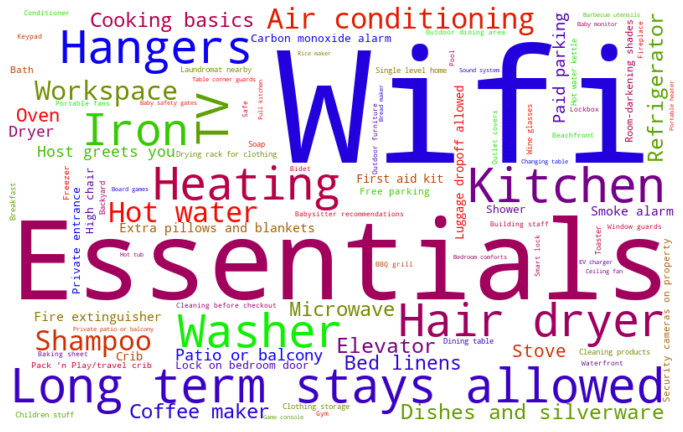

In [75]:
wordcloud = WordCloud(min_word_length = 3, background_color = 'white', width = 800, height = 500, 
                      max_words = 100, random_state = 20202020, min_font_size = 7, prefer_horizontal = 3/4,
                      colormap = 'brg')
wordcloud.generate_from_frequencies(amenities_count)

plt.figure(figsize = (12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# colormaps: https://matplotlib.org/stable/tutorials/colors/colormaps.html

In [76]:
top_amenities = [i[0] for i in amenities_count.most_common(select_top_amenities)]
#top_amenities.extend(['Pets allowed', 'Self check-in'])

print('Top amenities included: ', top_amenities)

Top amenities included:  ['Wifi', 'Essentials', 'Long term stays allowed', 'Kitchen', 'Washer', 'Hangers', 'Heating', 'Hair dryer', 'TV', 'Iron', 'Air conditioning', 'Hot water', 'Shampoo', 'Workspace', 'Dishes and silverware', 'Elevator', 'Refrigerator', 'Cooking basics', 'Microwave', 'Coffee maker']


In [77]:
def reduce_amenities(amenities_list):
    
    reduced_amenities = ['amenity_' + '_'.join(i.split()).lower() for i in amenities_list if i in top_amenities]
    
    return sorted(reduced_amenities)

In [78]:
listings['amenities'] = listings['amenities'].apply(lambda x: reduce_amenities(x))

In [79]:
for amenity_col in list(set().union(*listings['amenities'])):       
    listings[amenity_col] = listings['amenities'].apply(lambda x: 1 if amenity_col in x else 0)
    
listings.drop(['amenities'], 1, inplace = True)

#### Listing name and description may also be helpful. 
- Number of words in name
- Number of words in description
- Maybe some one hot encoding of certain words (luxurious, spacious, etc...)

In [80]:
listings[['name', 'description']].head()

,name,description
0,Huge flat for 8 people close to Sagrada Familia,110m2 apartment to rent in Barcelona. Located ...
1,Forum CCIB DeLuxe★Spacious &Elegant★Large Balcony,"Beautiful spacious apartment, large terrace, 5..."
2,Sagrada Familia area - Còrsega 1,A lovely two bedroom apartment only 250 m from...
3,Private Double room - Plaza Real,<b>The space</b><br />It is a Private double r...
4,VIDRE HOME PLAZA REAL on LAS RAMBLAS,Spacious apartment for large families or group...


Clean text from non alphabetic characters, stopwords

In [81]:
def process_text(text, remove_stopwords = False):    
    text = text.lower()
    
    # clean text
    text = re.compile('<.*?>').sub(' ', text) # html tags
    text = re.compile('[^a-z]').sub(' ', text) # nonletters      
    text = re.compile('\s+').sub(' ', text) # whitespaces
    text = text.strip() # trailing whitespaces
    
    if remove_stopwords == True:
        
        # remove stopwords
        text = ' '.join([word for word in text.split() if word not in (stopwords.words('english'))])
    
    return text

In [82]:
listings['description_cleaned'] = listings['description'].apply(lambda x: process_text(x) if isinstance(x, float) == False else x)
listings['name_cleaned'] = listings['name'].apply(lambda x: process_text(x) if isinstance(x, float) == False else x)

In [84]:
listings['name_cleaned_length'] = listings['name_cleaned'].apply(lambda x: len(x.split()) if isinstance(x, float) == False else 0)
listings['description_cleaned_length'] = listings['description_cleaned'].apply(lambda x: len(x.split()) if isinstance(x, float) == False else 0)

In [85]:
listings['name_cleaned_no_stopwords'] = listings['name'].apply(lambda x: process_text(x, remove_stopwords = True) if isinstance(x, float) == False else x)

In [86]:
word_vectorizer = CountVectorizer(ngram_range = (1, 2), analyzer = 'word')
sparse_matrix = word_vectorizer.fit_transform(listings['name_cleaned_no_stopwords'].astype(str))
frequencies = sum(sparse_matrix).toarray()[0]

word_counts = pd.DataFrame(frequencies, index = word_vectorizer.get_feature_names(), columns = ['frequency'])

In [87]:
word_counts.sort_values('frequency', ascending = False).head(20)

,frequency
room,3808
apartment,3507
barcelona,2428
habitaci,1512
en,1431
de,1417
sagrada,1303
bedroom,1257
double,1246
familia,1233


Based on unigrams and ngrams I can create a couple of feature indicating if something is mentioned in the name or description

In [91]:
#touristy_words = ['rialto', 'canal', 'marco'] # for venezia
touristy_words = ['sagrada', 'familia', 'gracia'] # for barcelona
pattern = '|'.join(touristy_words)

listings['name_touristy'] = 0
listings.loc[(listings['name_cleaned'].notnull() & 
              listings['name_cleaned'].str.contains(pattern)), 'name_touristy'] = 1

In [92]:
listings.drop(['name_cleaned', 'description_cleaned', 'name_cleaned_no_stopwords'], 1, inplace = True)

#### Check numerical features

In [93]:
listings.drop(['minimum_minimum_nights', 'maximum_minimum_nights', 'maximum_nights_avg_ntm', 'minimum_nights_avg_ntm',
               'minimum_maximum_nights', 'maximum_maximum_nights', 'host_listings_count', 'maximum_nights', 
               'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 
               'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms'], 1, inplace = True)

Drop items above 99th percentile

In [94]:
check_99th_perc = ['host_total_listings_count', 'bedrooms', 'beds', 'price', 'bathrooms_count', 'last_review_years']

perc_99_values = listings[check_99th_perc].describe(exclude = ['O'], 
                                           percentiles = [.99])\
                                          .T['99%']\
                                          .sort_values(ascending = False)

perc_99_values

price                        672.420000
host_total_listings_count    180.000000
beds                           9.000000
last_review_years              6.115068
bedrooms                       5.000000
bathrooms_count                4.000000
Name: 99%, dtype: float64

In [95]:
print(listings.shape)

for num_col in perc_99_values.index:
    
    perc_99_value = perc_99_values[num_col]
    listings = listings.loc[listings[num_col] <= perc_99_value]
    
print(listings.shape)

(17030, 73)
(11095, 73)


Check skewness and drop features based on that

In [96]:
skewness = listings.skew(skipna = True)
skewness = skewness[skewness.abs() >= 5]

print(skewness)

listings.drop(skewness.index, 1, inplace = True)

host_has_profile_pic    -19.833277
minimum_nights           10.710120
has_availability        -10.445535
number_of_reviews_ltm     5.793805
amenity_wifi             -7.615372
dtype: float64


Shouldnt have 0 or half a bathroom

In [98]:
listings = listings[listings['bathrooms_count'] >= 1]

The following numerical features could be binned to groups
- bedrooms
- bathrooms

In [83]:
# listings['bedrooms'] = listings['bedrooms'].apply(lambda x: '1_bedroom' if x == 1 else ('2_bedrooms' if x == 2 else '2_plus_bedrooms'))
# listings['bathrooms_count'] = listings['bathrooms_count'].apply(lambda x: '1_bathroom' if x == 1 else ('1.5_bathrooms' if x == 1.5 else ('2_bathrooms' if x == 2 else '2_plus_bathrooms')))

#### Check int features

In [85]:
# listings['accommodates'] = listings['accommodates'].apply(lambda x: '1' if x == 1 else ('2' if x == 2 else ('3' if x == 3 else ('4' if x == 4 else ('5' if x == 5 else '5_plus')))))

Check balances of 1/0 (true/false) features. Drop features with overwhelming majorities (>90% in one class)

In [99]:
true_false_features = listings.select_dtypes('int64').max()[listings.select_dtypes('int64').max() == 1].index.tolist()
print(true_false_features)

['host_is_superhost', 'host_identity_verified', 'instant_bookable', 'description_host', 'description_neighbourhood', 'bathrooms_are_shared', 'amenity_air_conditioning', 'amenity_hot_water', 'amenity_shampoo', 'amenity_iron', 'amenity_kitchen', 'amenity_heating', 'amenity_essentials', 'amenity_hangers', 'amenity_workspace', 'amenity_microwave', 'amenity_tv', 'amenity_dishes_and_silverware', 'amenity_elevator', 'amenity_refrigerator', 'amenity_long_term_stays_allowed', 'amenity_hair_dryer', 'amenity_cooking_basics', 'amenity_washer', 'amenity_coffee_maker', 'name_touristy']


In [100]:
listings[true_false_features].describe(percentiles = [.01, .1, .25, .5, .75, .9, .99]).T.drop(['mean', 'std'], 1).astype(int)

,count,min,1%,10%,25%,50%,75%,90%,99%,max
host_is_superhost,11031,0,0,0,0,0,0,1,1,1
host_identity_verified,11031,0,0,0,1,1,1,1,1,1
instant_bookable,11031,0,0,0,0,0,1,1,1,1
description_host,11031,0,0,0,0,0,1,1,1,1
description_neighbourhood,11031,0,0,0,0,0,1,1,1,1
bathrooms_are_shared,11031,0,0,0,0,0,1,1,1,1
amenity_air_conditioning,11031,0,0,0,0,1,1,1,1,1
amenity_hot_water,11031,0,0,0,0,1,1,1,1,1
amenity_shampoo,11031,0,0,0,0,1,1,1,1,1
amenity_iron,11031,0,0,0,1,1,1,1,1,1


In [101]:
L = listings.shape[0]
true_false_features_balance = {}

for i in true_false_features:
    
    n_true = listings[i].sum()
    n_false = L - n_true
    
    if n_true / L >= 0.9:
        
        true_false_features_balance[i] = n_true / L

true_false_features_balance

{'amenity_essentials': 0.9382648898558608}

In [102]:
listings.drop(true_false_features_balance.keys(), 1, inplace = True) 

### Main cleaning is now complete: final overview of listing dataset

In [103]:
listings.dtypes.value_counts()

int64      35
float64    20
object     12
dtype: int64

In [104]:
listings.isnull().sum()[listings.isnull().sum() > 0]

name                              2
description                      27
host_response_time             2786
host_response_rate             2786
host_acceptance_rate           2935
host_neighbourhood             2661
review_scores_accuracy          176
review_scores_cleanliness       174
review_scores_checkin           180
review_scores_communication     175
review_scores_location          181
review_scores_value             182
dtype: int64

In [107]:
listings = listings[listings['review_scores_value'].notnull()]
listings = listings[listings['review_scores_accuracy'].notnull()]          

Changes to be made after data analysis (next notebook):
- drop
    - 'neighbourhood_group_cleansed'
    - longitude
    - latitude
    
- treat
    - NaNs for host_response_time, rate and acceptance rate features. GBMs can take care of it, linreg needs manual adj

### Reviews

In [ ]:
# reviews[(reviews['reviewer_name'] == 'Kristof')] # &
# #         (reviews['listing_id'] == 19493233)]['comments'][328156]

Reviews data for now will not be used. Listings data has ratings, comment counts and other feedback related info

### Save cleaned file for further analysis

In [109]:
listings.to_csv('data/' + city + '/listings_cleaned.csv', index = False)